# Outline

First, we'll be pytorchifying our code even more; we're basically building up the core parts of torch.nn from scratch lol. From tanh, to linear, to batchnorm, to embedding and flatten, and then the sequential class, etc... Cool!

Then, we'll get to the cooooool RNNs and stuff!

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [3]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
	# print(x,y)
	print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])
## Mmm tasty x -> y examples (we got 182625 training examples hehe)

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd)) # generate the embedding matrix

layers = [
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
	layers[-1].weight *= 0.1 # last layer make less confident for better softmax initialised. (makes initial closer to equal prob distr output)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [10]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into the vectors || (batch_size, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat each char vector for some i'th training example together, from a [3,10] into a [30]. || I.e Concat into (batch_size (32), block_size * n_embed)
  ## OOOh, basically, the '-1' means "figure out what this is, but my other dimension MUST BE THIS (emb.shape[0]) in this case". So pog. And since we made it a 2d, yeah. It changed it to a 2D with [emb.shape[0], inferred value]
  
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.2966
  10000/  20000: 2.2322


In [11]:
emb.view(emb.shape[0], -1).shape, emb.shape


(torch.Size([32, 30]), torch.Size([32, 3, 10]))

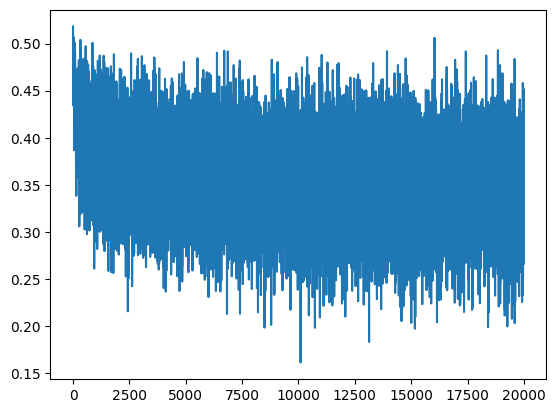

In [12]:
plt.plot(lossi)

In [13]:
# put layers into eval mode (for batchnorm)
for layer in layers:
	layer.training = False

In [14]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embed)
  
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.214060068130493
val 2.23262357711792


In [15]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (N, block_size, n_embd) || get the embedding of our current tri-example like '...'. 
      x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embed)
  
      for layer in layers:
        x = layer(x)
      probs = F.softmax(x, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ageor.
kymanarura.
nola.
khadricton.
nykh.
makalizey.
kash.
jeney.
zaulia.
hadio.
emh.
terather.
bhanth.
avike.
tin.
leamora.
naise.
nekyae.
lal.
faitliyones.


# ----------------------------------------------
Okay, now onto video.

First, let's fix our awful loss plot lmao.

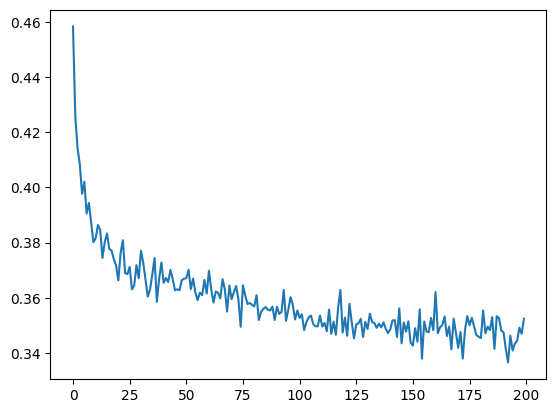

In [16]:
torch.arange(27).view(3,3,3) # Tada! Magic.
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1)) # Convert lossi into a 2d matrix, 100 columns, and then mean up column wise
# If you do the full 200k training steps, and use 1000 columns, you'll see it slow down like usual and then get a spike down, corresponding to our learning rate change

Cool!
Now, let's go pytorchify/modularise our code a bit more. We see that we're looking into the C embedding matrix and then changing the view of it in the forward pass, instead of just having it act like a layer or something. Let's change that.


In [33]:
class Embedding:
	def __init__(self, num_embeddings, embedding_dim) -> None:
		""" Embedding class for generating one in the forward pass

		Args:
			num_embeddings: number of embeddings you want to have (like vocab size -- the alphabet -- how many items do you want in a vector representation)
			embedding_dim: size of each embedding
		"""
		
		self.weight = torch.randn((num_embeddings, embedding_dim))

	def __call__(self, IX):
		"""_summary_

		Args:
			IX (_type_): Index of the embedding you want (e.g index 26 would be z, index 0 is '.')

		Returns:
			_type_: _description_
		"""
		self.out = self.weight[IX]
		return self.out

	def parameters(self):
		return [self.weight]

class Flatten:
	"""
	The flattening operation of the embeddings so we can throw it through our NN
	and it can actually read it, instead of some wack 3D shape.
	"""

	def __call__(self, x: torch.Tensor):
		self.out = x.view(x.shape[0], -1) # Force the x tensor into a 2D matrix, that must satisfy the 0th dim (# rows) being x.shape[0]. Basically, flattens 1st, 2nd dim into dim 1.
		return self.out

	def parameters(self):
		return []

In [34]:
torch.manual_seed(42)

In [35]:
# So now let's set up the new training loop with these in store!
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


layers = [
	Embedding(vocab_size, n_embd), 
	Flatten(),
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
	layers[-1].weight *= 0.1 # last layer make less confident for better softmax initialised. (makes initial closer to equal prob distr output)

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12097


In [36]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  x = Xb # since we moved Embedding stuff to layers list, we want the first 
  # x to be the indexes that we'll be looking up in the embedding first. yay!
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/  20000: 3.2966


Alright, instead of having a funky layers list, pytorch has a torch.nn.Sequential, where you basically store all the layers in a sequential order. Let's build that (at least the most important parts of it)

In [72]:
class Sequential:

	def __init__(self, layers) -> None:
		self.layers = layers

	def __call__(self, x):
		# Given an input, call all the layers sequentially, then return that final output.
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out
	def parameters(self):
		# Return number of parameters of everything in this sequential class
		return [p for layer in self.layers for p in layer.parameters()]

In [88]:
# So now let's set up the new training loop with these in store!
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


model =  Sequential([
	Embedding(vocab_size, n_embd), 
	Flatten(),
	Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
	layers[-1].weight *= 0.1 # last layer make less confident for better softmax initialised. (makes initial closer to equal prob distr output)

parameters = model.parameters() # boom!
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

22097


In [74]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb) # Boom! Just call the model, inputting Xb, and viola! Your logits (by definition, the output of your NN after its layer processing) are here :D
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    # print(p.grad)
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/  20000: 3.5251


In [75]:
# COoool. Now let's set it into eval mode so we can do stuff again.

In [76]:
# put layers into eval mode (for batchnorm)
for layer in model.layers:
	layer.training = False

In [77]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 3.4411187171936035
val 3.4406912326812744


In [79]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all '...'
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
# Btw, if you didn't run the "set self.training to false" above, this code would still work but it's using the wrong variables -- like the batchnorm would be doin le stuff on the wrong vars (over whole training set inputted) instead of the running vars. 
# And you could definitely tell if it's fucked in the sampling, because it would give an error: you can't get the variance of a single sample! (srs, it gives 'nan'. Also, it doesn't make sense to find spread of 1 sample) 

oblrevctavmqyvqmgzmvaeijwafletocexwqum.
myipabqhyugasxwsjldvvvyaeqkufzwqwukoikxtphynkwhumlhhxl.
tcgwzylekvwaaeq.
zsrlvnxkbmqjubfgemmdphtc.
zklgxjknygx.
e.
nywamimsefpptcgpkxxmkxixkjsftz.
raifpg.
cpjucrobpkprvktbhedlyvuiyegvguhmwlhskyhhhoeitlnhefdzrnekbimimpvzaqezffspmkwxtduibjhwzzdvaawzuqehagxwccvbmimpzseepqztjntxeqsqypnsckithtsvxrrvskkqxqecda.
yuarwrbavkheisrwvkuddtqcblbdfdpqlhkvavzzpnmelx.
bmbjkpzmiudfnxgpcheoouwarmdwclbexqllvdt.
hhlepldokuijpltfkwwodaqzpgfhbuvkweu.
qedggzrnnaaggfmyppkcfndp.
unubbuhvkqwhgumpujnvvjcba.
qohzudnflpzaetcqhdp.
b.
bdiccexfxclnvlszkwwicprvryeokoqzaihpygonqwqvlwqnaia.
evpojkluctnvdmpsdgczfxxa.
khjjlwzfmlfhpzrod.
qhguvdsefie.


In [67]:
torch.tensor(context).shape, torch.tensor([context]).shape # That's why you wanna wrape context in another list -- to make it 2d.

(torch.Size([3]), torch.Size([1, 3]))

# WaveNet time!

The general idea of this is to slowly diffuse the character information into the system, instead of getting the entire context and just CRUSHING IT straight up into a single layer with the embed. Like, we're losing stuff because how fast we're crushing it.

The way this works is: basically we get 2 characters, it makes a bigram, get two bigrams, makes a four gram, .... 
This is so that we basically crush the information slowly, as the info gets deeper and deeper into the NN. And the bet is that we can learn better from it.
https://www.youtube.com/watch?v=t3YJ5hKiMQ0 18:00

Since we're gonna be changing stuff, let's get a performance log. Like, look here for block size = 8: (when we're crushing 8 things at once :skull:)
### Performance log
original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
context: 3 -> 8 (22K params): train 1.918, val 2.027)

In [80]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [82]:
# print first 10 examples in the training sets
for x, y in zip(Xtr[:10], Ytr[:10]):
	# print(x,y)
	print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])
## Mmm tasty x -> y examples (we got 182625 training examples hehe)

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l


In [95]:
## Just setting up a 'scratch space' rough place where we can see what's happening in the model easily
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of just 4 examples
print(f'{ix=}')
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(f'{Xb.shape=}, {block_size=}')
print(Xb) # 4 examples, each 8 characters.

ix=tensor([167140, 168923,  72143,  47167])
Xb.shape=torch.Size([4, 8]), block_size=8
tensor([[ 0,  0,  0,  0,  0,  0, 20,  9],
        [ 0,  0,  0,  0,  0, 26,  5, 12],
        [ 0,  0,  0, 23,  9, 12, 12,  9],
        [ 0,  0, 20, 18,  1, 22, 15, 14]])


In [100]:
model.layers[0].out.shape # Output of embedding layer || Every char is translated into a 10 dimensional vector

torch.Size([4, 8, 10])

In [104]:
model.layers[1].out.shape # Output of Flatten layer

torch.Size([4, 80])

In [105]:
model.layers[2].out.shape # Output of Linear Layer


torch.Size([4, 200])